In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from torch import float32

In [191]:
class NoisyIPD:
    def __init__(self, game, p, gamma):
        """
        args:
            game:   torch.tensor; reward matrix of game, shape = n_states x n_actions, (For IPD = 4x2)
            p:      float; probability of memory of other agents action mutating
            gamma:  float; discount factor
    
        """
        self.game = game.float()
        self.gamma = gamma
        self.P = self.generate_P_matrix(p)

    def generate_P_matrix(self,p):
        """
        Generates the matrix of probabilites of agents observations conditional on state

        args:
            p:  float; probability of memory of other agents action mutating
        returns:
            P:  torch.tensor;  shape = 4x4x4 (num_states x num_observations x num_observations)
            
            P_{kij} = P(Agent 0 observes i, Agent 1 observes j | Currently in state k)
        """
        p1_matrix = torch.tensor([
            [1-p,p,0,0],
            [p,1-p,0,0],
            [0,0,1-p,p],
            [0,0,p,1-p]
        ], dtype=torch.float32).unsqueeze(-1)
        p2_matrix = torch.tensor([
            [1-p,0,p,0],
            [0,1-p,0,p],
            [p,0,1-p,0],
            [0,p,0,1-p]
        ], dtype=torch.float32).unsqueeze(-1)

        return torch.matmul(p1_matrix,p2_matrix.mT)

    def generate_Q_matrix(self, policy_1, policy_2):
        """
        Generates matrix of probabilities of transitioning to a given state conditional on what agents observe

        args:
            policy_1,policy_2:  torch.tensor; shape = 4, entries are probability of playing confess in the given state 
        
        returns:
            Q:  torch.tensor; shape = 4x4x4 
            
            Q_{lij} = Pr(Transitioning to state l | Agent 0 sees i, Agent 1 sees j)
        """
        p1 = policy_1.unsqueeze(-1)
        p2 = policy_2.unsqueeze(-1)
        return torch.stack(((1-p1)@(1-p2).T, (1-p1)@p2.T, p1@(1-p2).T, p1@p2.T))


    def evaluate_policies(self, policy_1,policy_2):
        """
        Calculates the values of the states under the two policies

        args:
            policy_1,policy_2:  torch.tensor; shape = 4, entries are probability of playing confess in the given state
        
        returns:
            values: torch.tensor; shape = 2x4 (num_agents x num_states)
        
        """
        #get transition matrix for given policies
        Q = self.generate_Q_matrix(policy_1,policy_2)

        # sum over ij of P_kij * Q_lij
        PQ = torch.einsum("kij, lij -> kl", self.P, Q)

        #calculate matrix to be inverted
        self.subtracted_matrix = torch.eye(self.game.shape[1]) - self.gamma * PQ
        
        #calculate inverse
        inverse_matrix = torch.linalg.solve(self.subtracted_matrix, torch.eye(4))

        #apply inverse reward matrix to calculate state values
        values = torch.matmul(inverse_matrix, self.game.T).T

        return values


    def optimize(self, policies, policy_index, learning_rate=0.05, num_iterations = 1000, randomize = False):

        """
        Given two policies, optimise one policy while holding the other one constant. 
        Opitmisation is with regards to the sum of values of the states under the given policies

        args:
            policies:       tuple; policies to be evaluated, each policy is a tensor of shape 4
            policy_index:   int; index of the policy to be optimised, the other policy is held constant
            learning_rate:  float; learning rate for optimiser
            num_iterations: int; how many interations to optimise for
            randomize:      bool; whether to randomize the policy being optimized
        
        returns:
            loss_dict:  dict; dictionary of logs of values during training
                'policy' = policy of agent being optimised
                'values' = values of states
                'loss'  = - sum of state values for policy being oprimised
        """

        #Policy to be optimised
        policy = policies[policy_index]

        #Randomize if desired
        policy = torch.rand(policy.shape) if randomize else policy

        #Policy to be held constant
        rival_policy = policies[1-policy_index]

        #Logit transformation
        logit_policy = torch.logit(policy).detach().requires_grad_(True)

        #Optimizer to be used
        optimizer = torch.optim.Adam([logit_policy], lr=learning_rate)

        loss_dict = defaultdict(lambda: [])

        for i in range(num_iterations):
            optimizer.zero_grad()

            policy = torch.sigmoid(logit_policy)
            values = self.evaluate_policies(policy,rival_policy)
            loss = -values[policy_index].sum() 
            loss.backward()


            loss_dict["policy"].append(policy.detach())
            loss_dict["values"].append(values[policy_index])
            loss_dict["loss"].append(loss.item())

            optimizer.step()
        
        
        return loss_dict


In [210]:
#Game Hyperparameters
reward_matrix = torch.tensor([
    [3, 0, 4, 1],
    [3, 4, 0, 1]
    ])
gamma = 0.999
p = 0
Game = NoisyIPD(game = prisoners_dilemma, p = p, gamma = gamma)

#Policies to be tested
policies = [
    torch.tensor([0.1,0.1,0.1,0.1],dtype = float32),
    torch.tensor([0,1,1,1], dtype = float32)
    ]

#Optimization Hyperparemetrs
policy_index = 0
lr = 0.05
num_iterations = 20000
randomize = True

loss_dict = Game.optimize(policies = policies, policy_index=policy_index, num_iterations=num_iterations, randomize = randomize)

Final Policy = tensor([0.0000, 0.9999, 1.0000, 1.0000])


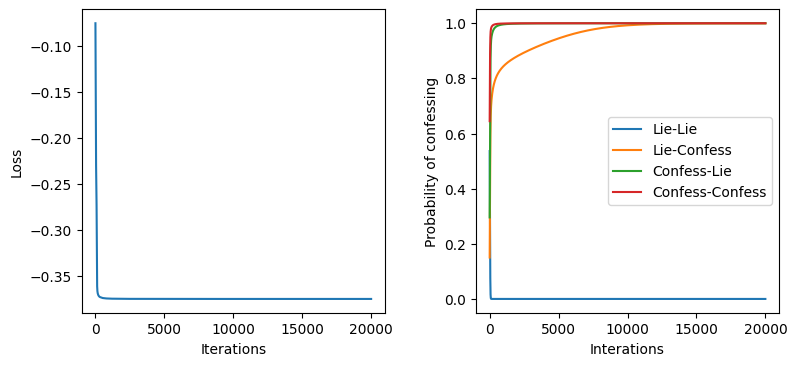

In [211]:
state_desctiptions = {
    0: 'Lie-Lie',
    1: 'Lie-Confess',
    2: 'Confess-Lie',
    3: 'Confess-Confess'
}

def plot_results(game, loss_dict):
    scale = game.game.max()*4/(1-game.gamma)
    
    fig,axs = plt.subplots(ncols=2,figsize = (9,9))
    for ax in axs:
        ax.set_box_aspect(1)

    loss = np.array(loss_dict['loss'])
    axs[0].plot(loss/scale)
    axs[0].set(xlabel = 'Iterations', ylabel='Loss')

    policies = np.array(loss_dict['policy']).T
    for i,s in enumerate(policies):
        axs[1].plot(s, label = state_desctiptions[i])
        axs[1].set(xlabel = 'Interations', ylabel = 'Probability of confessing')
        plt.legend()

    print(f"Final Policy = {torch.round(loss_dict['policy'][-1],decimals = 5)}")

    plt.subplots_adjust(wspace = 0.3)
    plt.show()



plot_results(Game,loss_dict)